In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner
from scipy.stats import norm
from getdist import plots, MCSamples
from scipy.integrate import quad

## Gaussian Signal with Unknown Mean and Standard Deviation

Forward Model: The signal $x$ is modeled as a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$, with observations $y$ being the true signal plus some Gaussian noise.

In [40]:
# Forward model for a Gaussian signal
def gaussian_forward_model(y, mu, sigma):
    """ Forward model for a Gaussian signal with mean mu and standard deviation sigma. """
    return mu + sigma * y

In [41]:
# Generate data
np.random.seed(42)
true_mu = 5.0
true_sigma = 1.0
y = np.linspace(-3, 3, 50)  # Independent variable
x = gaussian_forward_model(y, true_mu, true_sigma) + np.random.normal(0, 0.5, size=y.shape)  # Observations with noise

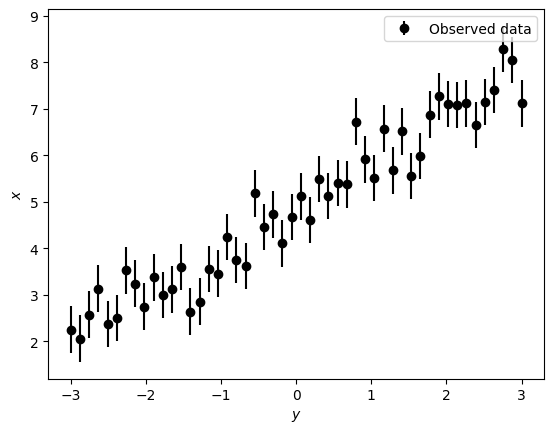

In [42]:
# Plot the generated data
plt.errorbar(y, x, yerr=0.5, fmt='o', label="Observed data")
plt.xlabel("$y$")
plt.ylabel("$x$")
plt.legend()
plt.show()

We can write down the likelihood function as a Gaussian over the observed data given the parameters $\mu$ and $\sigma$:

In [44]:
def log_like(params, y, x):
    """ Log-likelihood function for a Gaussian signal with mean mu and std sigma. """
    mu, sigma = params
    model = gaussian_forward_model(y, mu, sigma)
    return norm.logpdf(x, model, 0.5).sum()

# Test the log-likelihood function with true parameters
log_like([true_mu, true_sigma], y, x)

-33.918095840468524

In [45]:
# Initial guess for the parameters
initial_guess = [0.0, 1.0]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((-10, 10), (0.1, 5))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda params: -log_like(params, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (true_mu, true_sigma)))


MLE parameters: [4.88726305 0.9516805 ]; true parameters: (5.0, 1.0)


In [ ]:
# Log-prior function
def log_prior(params):
    mu, sigma = params
    if -10 < mu < 10 and 0.1 < sigma < 5:
        return 0
    else:
        return -np.inf
    
# Log-posterior function
def log_post(params, y, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, y, x)

Removed no burn in


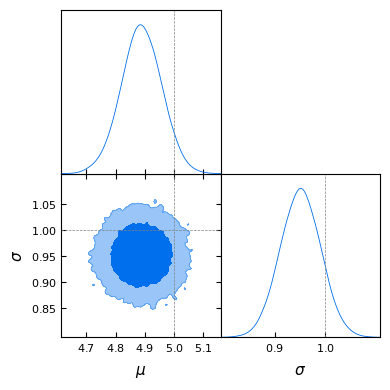

In [63]:
samples = MCSamples(samples=flat_samples, names=['mu', 'sigma'], labels=['\mu', '\sigma'])
# Create the plotter
g = plots.get_subplot_plotter()
# Create the triangle plot
g.triangle_plot(samples, filled=True, markers={'mu': true_mu, 'sigma': true_sigma})
plt.show()

## Supernova Light Curve Model

In [86]:
# Supernova light curve model
def sn_light_curve(t, t_peak, M_peak, sigma_rise=10, sigma_decay=20):
    """ Light curve model for a supernova. """
    rise = np.exp(-(t - t_peak) / sigma_rise)
    decay = np.exp(-(t - t_peak) / sigma_decay)
    return M_peak - 2.5 * np.log10(rise + decay)

In [94]:
# Generate synthetic data
np.random.seed(4)
true_t_peak = 30.0
true_M_peak = -19.0
t = np.linspace(0, 100, 50)
y_true = sn_light_curve(t, true_t_peak, true_M_peak)
y_obs = y_true + np.random.normal(0, 0.1, size=t.shape)

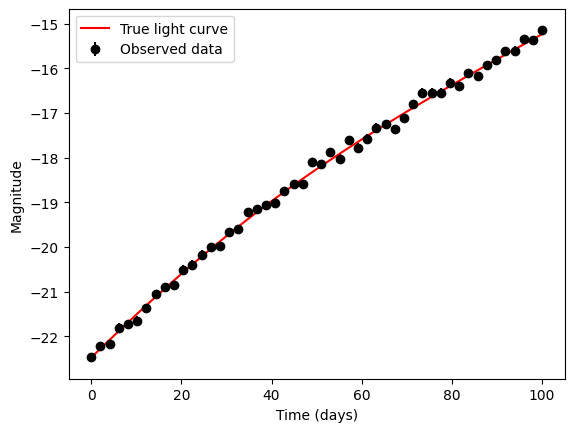

In [95]:
# Plot the generated data
plt.errorbar(t, y_obs, yerr=0.1, fmt='o', color='k', label="Observed data")
plt.plot(t, y_true, label="True light curve", color='r')
plt.xlabel("Time (days)")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

In [96]:
# Log-Likelihood Function
def log_like(params, t, y):
    """ Log-likelihood function for the supernova light curve model. """
    t_peak, M_peak = params
    model = sn_light_curve(t, t_peak, M_peak)
    return norm.logpdf(y, model, 0.1).sum()

In [97]:
# Initial guess for the parameters
initial_guess = [25.0, -18.0]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 100), (-20, -15))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda params: -log_like(params, t, y_obs), initial_guess, minimizer_kwargs=minimizer_kwargs)
print("MLE parameters: {}; true parameters: {}".format(opt.x, (true_t_peak, true_M_peak)))

MLE parameters: [ 30.70578367 -18.94445445]; true parameters: (30.0, -19.0)


In [98]:
# Log-prior function
def log_prior(params):
    t_peak, M_peak = params
    if 0 < t_peak < 100 and -20 < M_peak < -15:
        return 0
    else:
        return -np.inf

# Log-posterior function
def log_post(params, t, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, t, y)

In [99]:
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(t, y_obs))

# Initialize walkers around the MLE result
pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

100%|██████████| 5000/5000 [00:06<00:00, 717.60it/s]


Removed no burn in


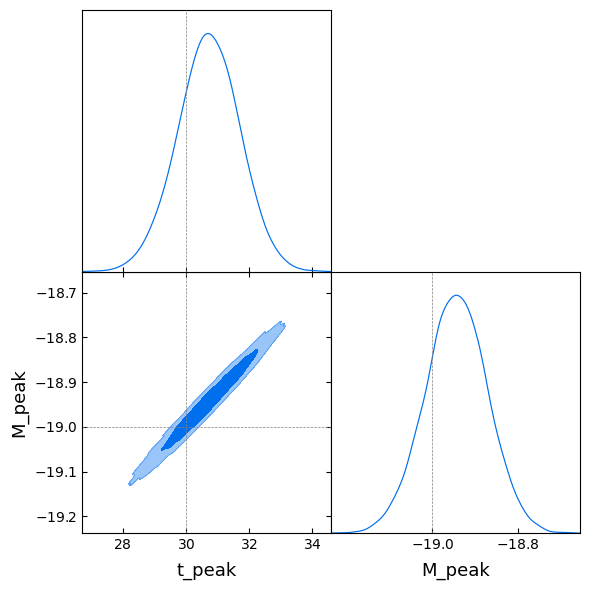

In [100]:
# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['t_peak', 'M_peak'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'t_peak': true_t_peak, 'M_peak': true_M_peak})

plt.show()

## Supernova Lumonisity Distance

We'll consider a simplified model for the luminosity distance to supernovae, which depends on the cosmological parameters $\Omega_m$ (matter density parameter) and $H_0$ (Hubble constant).

The luminosity distance $d_L$ for a flat universe ($\Omega_k = 0$) can be approximated using the cosmological parameters. The apparent magnitude $m$ of a supernova is related to its luminosity distance.



For simplicity, we'll assume the following:
1. We have a set of supernovae with observed apparent magnitudes $m_{\text{obs}}$ and redshifts $z$.
2. The theoretical apparent magnitude $m_{\text{th}}$ is given by the distance modulus $\mu$
$$\mu = 5 \log_{10}(d_L) + 25,$$ 
where $d_L$ is the luminosity distance.
3. The luminosity distance $d_L$ depends on the cosmological parameters $\Omega_m$ and $H_0$.

Given the redshift $z$, the luminosity distance $d_L$ can be approximated by:
$$d_L = \frac{c(1+z)}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + (1-\Omega_m)}},$$
where $c$ is the speed of light.
​	


### Analytical Likelihood
We'll assume the observed magnitudes $m_{\text{obs}}$ have Gaussian errors, and write down the likelihood function as a Gaussian over the observed data given the parameters $\Omega_m$ and $H_0$:
$$\mathcal{L}(\Omega_m, H_0) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left(-\frac{(m_{\text{obs},i} - m_{\text{th},i})^2}{2\sigma_i^2}\right),$$
where $N$ is the number of supernovae, $m_{\text{obs},i}$ is the observed apparent magnitude of supernova $i$, $m_{\text{th},i}$ is the theoretical apparent magnitude of supernova $i$, and $\sigma_i$ is the error in the observed apparent magnitude of supernova $i$.

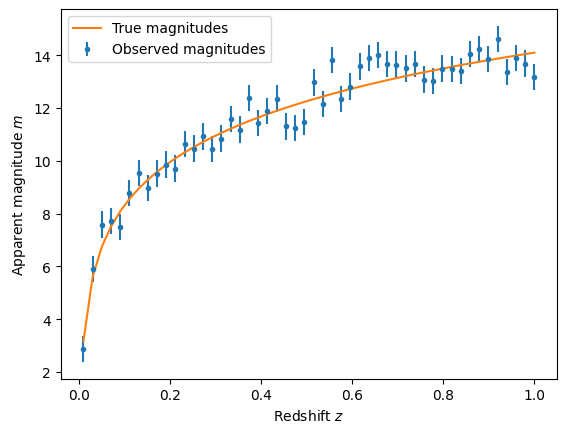

In [140]:
# Constants
c = 299792.458  # Speed of light in km/s

# True cosmological parameters
true_Omega_m = 0.3
true_H0 = 70.0  # Hubble constant in km/s/Mpc

# Redshifts of the supernovae
z = np.linspace(0.01, 1.0, 50)

# Luminosity distance function
def luminosity_distance(z, Omega_m, H0):
    integrand = lambda z_prime: 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))
    d_L = np.array([quad(integrand, 0, z_i)[0] for z_i in z])
    return (c * (1 + z) * d_L) / H0

# Generate synthetic data
d_L_true = luminosity_distance(z, true_Omega_m, true_H0)
m_true = 5 * np.log10(d_L_true / 10)
m_obs = m_true + np.random.normal(0, 0.5, len(m_true))  # Adding Gaussian noise

# Plot synthetic data
plt.errorbar(z, m_obs, yerr=0.5, fmt='.', label='Observed magnitudes')
plt.plot(z, m_true, label='True magnitudes')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()


In [141]:

# Define the log-likelihood function
def log_like(params, z, m_obs):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    sigma_m = 0.5  # Assumed standard deviation of magnitudes
    return -0.5 * np.sum(((m_obs - m_th) / sigma_m)**2)

# Initial guess for the parameters
initial_guess = [0.5, 60.0]

# Perform the optimization using basinhopping
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 1), (50, 100))}
opt = basinhopping(lambda params: -log_like(params, z, m_obs), initial_guess, minimizer_kwargs=minimizer_kwargs)
print("MLE parameters: {}; true parameters: {}".format(opt.x, (true_Omega_m, true_H0)))


MLE parameters: [ 0.308347   67.23274838]; true parameters: (0.3, 70.0)


In [142]:
# Log-prior function
def log_prior(params):
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0
    else:
        return -np.inf

# Log-posterior function
def log_post(params, z, m_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, z, m_obs)

In [143]:
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(z, m_obs))

# Initialize walkers around the MLE result
pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True)

# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

100%|██████████| 5000/5000 [01:38<00:00, 50.79it/s]


Removed no burn in


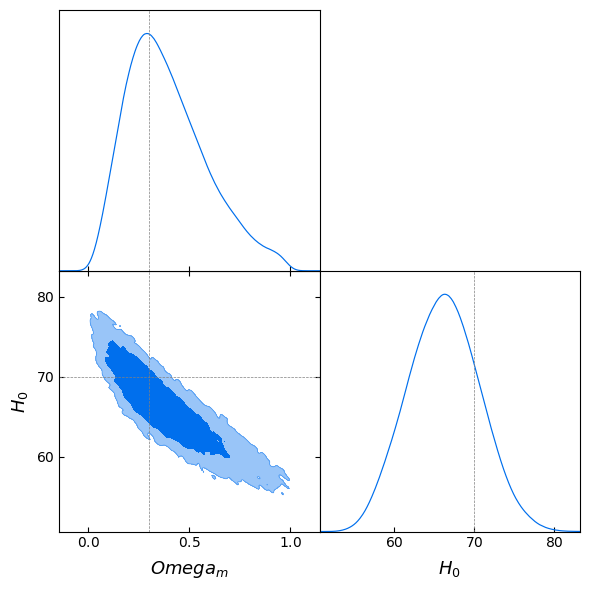

In [146]:
# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'Omega_m': true_Omega_m, 'H0': true_H0})

plt.show()

# ABC

In [184]:
# noise level
sigma = 0.5
# Forward model to simulate observed magnitudes
def luminosity_distance_simulator(params, z):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    m_sim = m_th + np.random.normal(0, sigma, len(m_th))
    return m_sim

# Distance metric: Mean Squared Error
def mse(x, x_fwd):
    return np.sum((x - x_fwd) ** 2) / len(x)

In [150]:
# ABC Algorithm
def abc(y, x, eps_thresh=0.5, n_samples=1000):
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 50], high=[1, 100])  # Priors; theta ~ p(theta)
        x_fwd = luminosity_distance_simulator(params, y)  # x ~ p(x|theta)
        eps = mse(x, x_fwd)  # Distance metric; d(x, x_fwd)
        total_attempts += 1

        # If accepted, add to samples
        if eps < eps_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)

In [157]:
# Run ABC
n_samples = 5000
eps_thresh = 0.3
post_samples = abc(z, m_obs, eps_thresh=eps_thresh, n_samples=n_samples)

Accepted Samples: 100%|██████████| 5000/5000 [00:34<00:00, 144.57samples/s, acceptance_ratio=0.125]


Removed no burn in


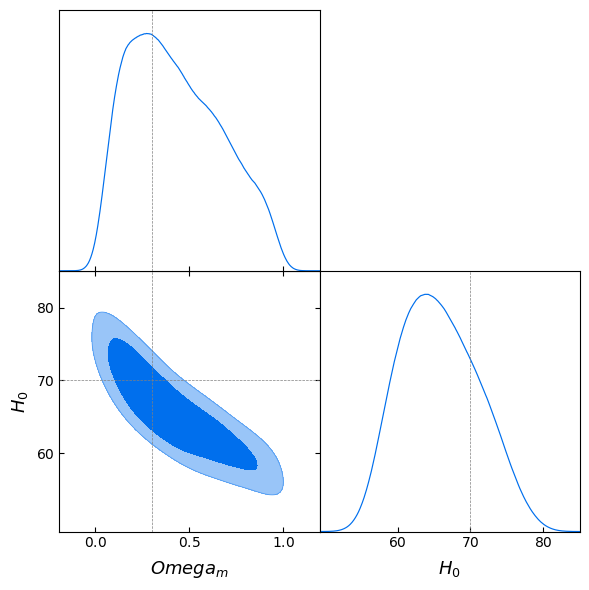

In [158]:
# GetDist plotting
samples = MCSamples(samples=post_samples, names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'Omega_m': true_Omega_m, 'H0': true_H0})

plt.show()

# NRE

In [192]:
# Generate training data
n_train = 10_000
theta_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_train, 2))  # Parameter proposal
x_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

100%|██████████| 10000/10000 [00:06<00:00, 1506.52it/s]


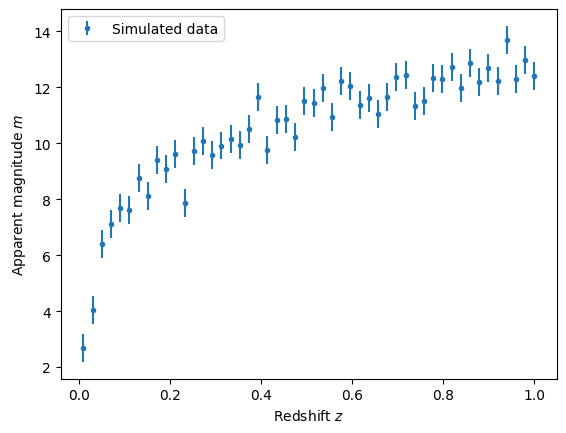

In [195]:
# plot the training data
plt.errorbar(z, x_samples[19], yerr=sigma, fmt='.', label='Simulated data')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()

In [196]:
# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

In [198]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

In [ ]:
class NeuralRatioEstimator(pl.LightningModule):
    """ Simple neural likelihood-to-evidence ratio estimator, using an MLP as a parameterized classifier. """
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, theta):
        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device) 
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [199]:
# Initialize the model
nre = NeuralRatioEstimator(x_dim=50, theta_dim=2)

# Evaluate initial loss
nre.loss(x_samples[:64], theta_samples[:64])

tensor([0.6868, 0.6990, 0.6891, 0.6970, 0.6892, 0.6971, 0.6873, 0.6991, 0.6890,
        0.6972, 0.6873, 0.6990, 0.6875, 0.6988, 0.6881, 0.6980, 0.6884, 0.6978,
        0.6892, 0.6969, 0.6887, 0.6977, 0.6882, 0.6980, 0.6876, 0.6985, 0.6883,
        0.6980, 0.6868, 0.6996, 0.6879, 0.6984, 0.6902, 0.6959, 0.6883, 0.6978,
        0.6884, 0.6979, 0.6871, 0.6992, 0.6881, 0.6982, 0.6887, 0.6978, 0.6885,
        0.6977, 0.6876, 0.6988, 0.6876, 0.6987, 0.6876, 0.6987, 0.6883, 0.6980,
        0.6866, 0.6995, 0.6874, 0.6991, 0.6888, 0.6974, 0.6887, 0.6976, 0.6882,
        0.6981, 0.6871, 0.6991, 0.6894, 0.6970, 0.6887, 0.6976, 0.6871, 0.6992,
        0.6875, 0.6989, 0.6883, 0.6981, 0.6876, 0.6986, 0.6873, 0.6989, 0.6882,
        0.6981, 0.6893, 0.6969, 0.6885, 0.6978, 0.6888, 0.6975, 0.6892, 0.6972,
        0.6882, 0.6981, 0.6885, 0.6979, 0.6885, 0.6978, 0.6878, 0.6985, 0.6869,
        0.6996, 0.6875, 0.6988, 0.6887, 0.6976, 0.6868, 0.6994, 0.6885, 0.6979,
        0.6885, 0.6976, 0.6876, 0.6987, 

In [200]:
from torch.utils.data import DataLoader, random_split, TensorDataset

# Create dataset
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)
dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

# Train the model
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 73.0 K
------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/atersenov/miniconda3/envs/astrostat24/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/atersenov/miniconda3/envs/astrostat24/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 71/71 [00:05<00:00, 13.23it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 71/71 [00:05<00:00, 13.20it/s, v_num=2]


In [215]:
def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits. """
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze()

# Generate synthetic data for testing
theta_test = np.array([0.3, 70.0])
x_test = luminosity_distance_simulator(theta_test, z)

log_like(theta_test, x_test)

tensor(2.3717, grad_fn=<SqueezeBackward0>)

In [216]:
def log_prior(theta):
    Omega_m, H0 = theta
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0.0  # Uniform prior
    else:
        return -np.inf  # Log(0) for invalid values
    
def log_post(theta, x):
    """ Log-posterior distribution, for sampling. """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

In [ ]:
# Run MCMC sampling
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = theta_test + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 50000, progress=True)

In [208]:
# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=10000, flat=True)

In [ ]:
# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'Omega_m': true_Omega_m, 'H0': true_H0})

plt.show()